## Get the data
Downloads free daily candle info from cryptodatadownload.com. You only need to run this to pull new daily candle data.
License: https://creativecommons.org/licenses/by-nc-sa/4.0/

In [2]:
# Download the data and remove first line
#!curl -L -o ./Bitstamp_BTCUSD_d.csv https://www.cryptodatadownload.com/cdd/Bitstamp_BTCUSD_d.csv
#!sed -i '1d' ./Bitstamp_BTCUSD_d.csv


## Calculate basic statistics
Define start date to filter out earlier data.

In [3]:
import numpy as np
import pandas as pd
from IPython.display import Markdown, display

start_date = '2020-10-01'

data = pd.read_csv('./Bitstamp_BTCUSD_d.csv')
data['date'] = pd.to_datetime(data['date'])
data = data[::-1]  # Reverse the data order
data = data[data['date'] >= start_date]

data['daily_return'] = data['close'].pct_change()


# Remove rows with NaN values in 'daily_return'
data.dropna(subset=['daily_return'], inplace=True)

# Calculate basic statistics
mean_return = data['daily_return'].mean()
std_dev = data['daily_return'].std()
annualized_volatility = std_dev * np.sqrt(365)  # Assuming 365 period
annualized_return = (1 + mean_return)**365 - 1  # Compound annual return

# Calculate additional metrics
# Sharpe Ratio (assuming risk-free rate of 0 for simplicity)
sharpe_ratio = (mean_return / std_dev) * np.sqrt(365)

# Maximum Drawdown
cumulative_returns = (1 + data['daily_return']).cumprod()
peak = cumulative_returns.expanding().max()
drawdown = (cumulative_returns / peak) - 1
max_drawdown = drawdown.min()

# Win Rate
win_rate = len(data[data['daily_return'] > 0]) / len(data)

# Value at Risk (95% confidence)
var_95 = np.percentile(data['daily_return'], 5)

metrics = {
    "Metric": [
        "Mean Daily Return",
        "Daily Volatility",
        "Annualized Volatility",
        "Annualized Return",
        "Sharpe Ratio",
        "Maximum Drawdown",
        "Win Rate",
        "Value at Risk (95%)"
    ],
    "Value": [
        f"{mean_return*100:.2f}%",
        f"{std_dev:.6f}",
        f"{annualized_volatility:.6f}",
        f"{annualized_return*100:.2f}%",
        f"{sharpe_ratio:.6f}",
        f"{max_drawdown*100:.2f}%",
        f"{win_rate*100:.2f}%",
        f"{var_95:.6f}"
    ]
}

summary_table = pd.DataFrame(metrics)
markdown_output = summary_table.to_markdown(index=False)

print("Basic Data Information:")
display(Markdown(markdown_output))

Basic Data Information:


| Metric                | Value     |
|:----------------------|:----------|
| Mean Daily Return     | 0.16%     |
| Daily Volatility      | 0.030858  |
| Annualized Volatility | 0.589550  |
| Annualized Return     | 77.97%    |
| Sharpe Ratio          | 0.978505  |
| Maximum Drawdown      | -76.66%   |
| Win Rate              | 50.60%    |
| Value at Risk (95%)   | -0.046876 |

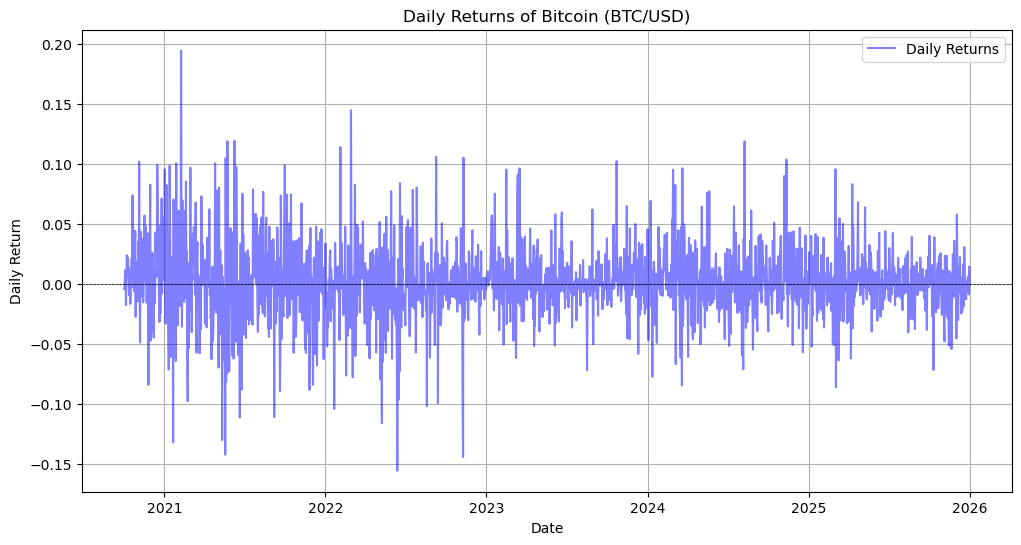

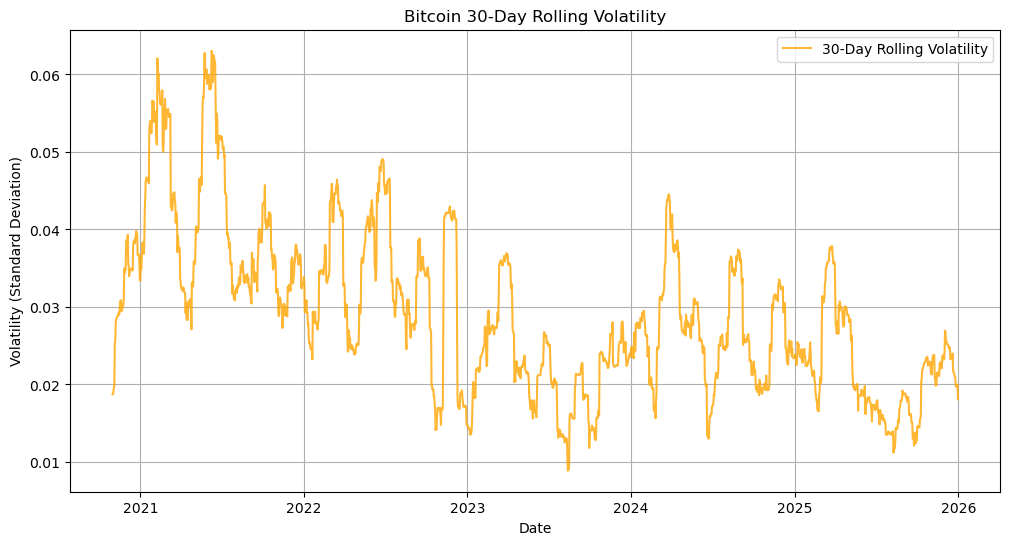

In [4]:
# plot the daily volatility
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['daily_return'], label='Daily Returns', color='blue', alpha=0.5)
plt.title('Daily Returns of Bitcoin (BTC/USD)')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.legend()
plt.grid()
plt.show()

# Calculate rolling volatility (standard deviation) over a 30-day window
data['rolling_volatility'] = data['daily_return'].rolling(window=30).std()

# Plot the rolling volatility
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['rolling_volatility'], label='30-Day Rolling Volatility', color='orange', alpha=0.8)
plt.title('Bitcoin 30-Day Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility (Standard Deviation)')
plt.legend()
plt.grid()
plt.show()

In [5]:
# Display data summary
print("\nData Summary:")
print(data[['close','Volume BTC', 'daily_return', 'rolling_volatility']].describe())


Data Summary:
              close    Volume BTC  daily_return  rolling_volatility
count    1917.00000   1917.000000   1917.000000         1888.000000
mean    52643.85735   2859.935305      0.001580            0.029108
std     29861.96602   3107.745900      0.030858            0.010546
min     10553.66000      3.192223     -0.155526            0.008876
25%     27933.00000   1264.645405     -0.012711            0.021268
50%     44025.99000   1990.071266      0.000218            0.027543
75%     67938.00000   3153.029650      0.015014            0.035554
max    124728.00000  40786.964254      0.194503            0.063060


## Simple closing prices line with EMA

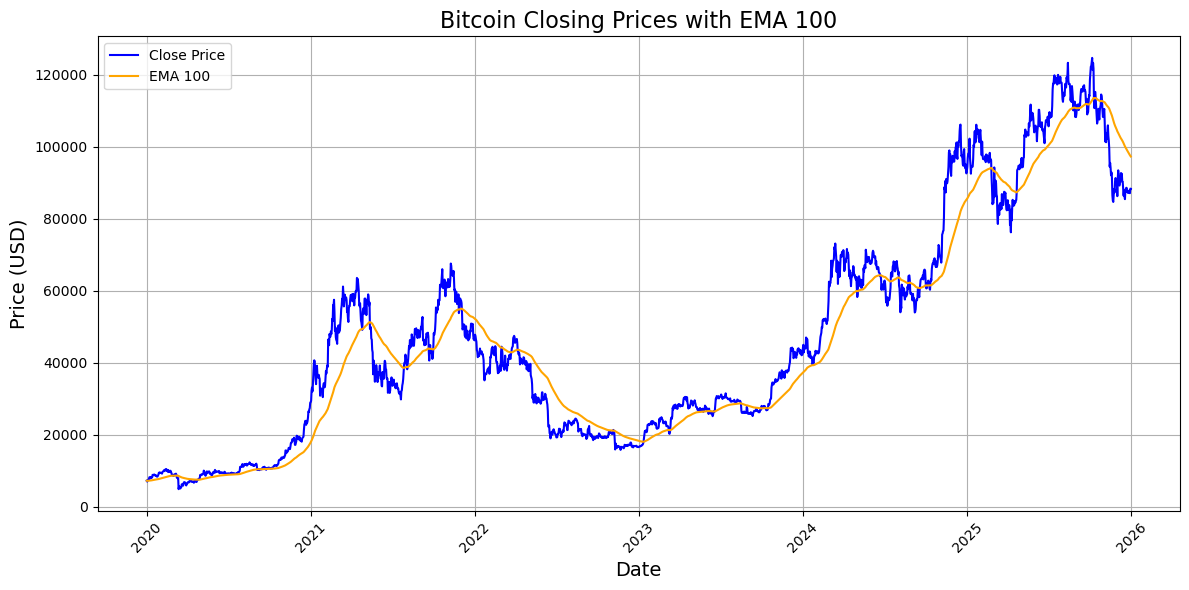

In [5]:
import matplotlib.pyplot as plt

start_date = '2020-01-01'

data = pd.read_csv('./Bitstamp_BTCUSD_d.csv')
data['date'] = pd.to_datetime(data['date'])
data = data[::-1]  # Reverse the data order



data = data[data['date'] >= start_date]
data['EMA_100'] = data['close'].ewm(span=100, adjust=False).mean()

plt.figure(figsize=(12, 6))

# Plot close prices
plt.plot(data['date'], data['close'], label='Close Price', color='blue')

# Plot EMA
plt.plot(data['date'], data['EMA_100'], label='EMA 100', color='orange')

# titles and labels
plt.title('Bitcoin Closing Prices with EMA 100', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

## Display PSAR, RSI, and EMA

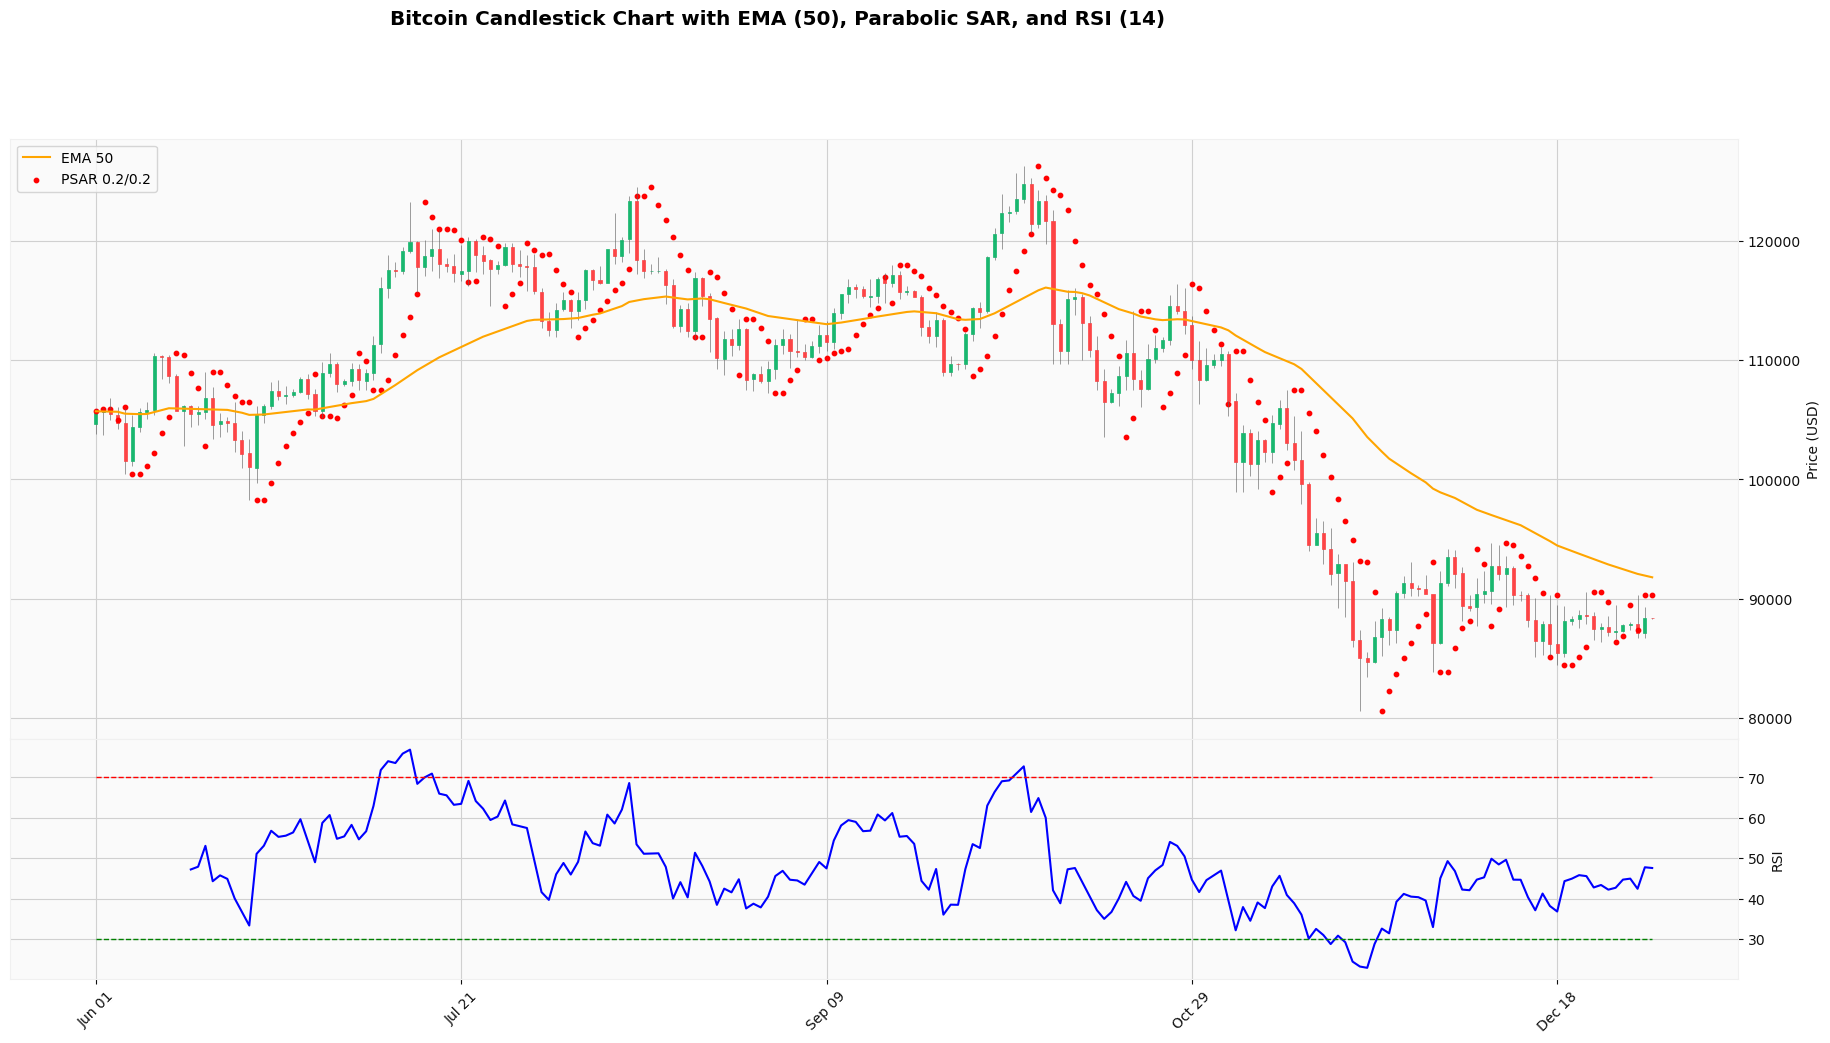

In [6]:
import mplfinance as mpf
from ta.trend import PSARIndicator
from ta.momentum import RSIIndicator
import warnings



ema_span = 50
psar_step = 0.2 # Default acceleration factor
psar_max = 0.2 # Default maximum acceleration factor
rsi_period = 14
start_date = '2025-06-01'  # Define the start date for filtering


warnings.filterwarnings("ignore", category=FutureWarning)

#Read and sort the data
data = pd.read_csv('./Bitstamp_BTCUSD_d.csv')
data['date'] = pd.to_datetime(data['date'])
data = data[::-1]  # Reverse the data order

data = data[data['date'] >= start_date] # Remove data before the start date

# set'date' column as the index (required for mplfinance)
data.set_index('date', inplace=True)


# calculate EMA
data[f'EMA_{ema_span}'] = data['close'].ewm(span=ema_span, adjust=False).mean()

psar = PSARIndicator(
    high=data['high'],
    low=data['low'],
    close=data['close'],
    step=psar_step,
    max_step=psar_max
)
data['psar'] = psar.psar()

# calculate RSI
data['RSI_upper'] = 70 # Overbought threshold
data['RSI_lower'] = 30 # Oversold threshold
rsi = RSIIndicator(close=data['close'], window=rsi_period)
data['RSI'] = rsi.rsi()

# prepare the additional EMA, PSAR overlays, and RSI subplot for mplfinance
additional_plots = [
    mpf.make_addplot(data[f'EMA_{ema_span}'], color='orange', width=1.5, label=f'EMA {ema_span}'),
    mpf.make_addplot(data['psar'], color='red', scatter=True, markersize=10, label=f'PSAR {psar_step}/{psar_max}'),
    mpf.make_addplot(data['RSI'], panel=1, color='blue', width=1.5, ylabel='RSI'),  # Add RSI as a subplot
    mpf.make_addplot(data['RSI_upper'], panel=1, color='red', width=1, linestyle='--'),
    mpf.make_addplot(data['RSI_lower'], panel=1, color='green', width=1, linestyle='--')
]

# plot candlesticks
fig, axlist = mpf.plot(
    data,
    type='candle',
    style='yahoo',
    addplot=additional_plots,
    title=f'Bitcoin Candlestick Chart with EMA ({ema_span}), Parabolic SAR, and RSI ({rsi_period})',
    ylabel='Price (USD)',
    figsize=(24, 12),
    volume=False,  # Set to True if you want a volume subplot
    returnfig=True  # Required to modify legend position
)

# adjust legend position to upper left
for ax in axlist:
    handles, labels = ax.get_legend_handles_labels()
    if handles:  # Check if there are any handles to avoid errors
        ax.legend(handles, labels, loc='upper left')  # Move legend to top left



## Save the chart to file

In [15]:
# save output .png
output_file = f'bitcoin_candlestick_chart_ema{ema_span}_rsi{rsi_period}.png'
fig.savefig(output_file)

print(f"Chart saved as {output_file}")


Chart saved as bitcoin_candlestick_chart_ema50_rsi14.png
